## Efficient Frontier

**Joshua and Jingwen**

The Efficient Frontier represents the set of optimal portfolios offering the highest expected return for a given level of risk. It is derived by analyzing different portfolio combinations and plotting risk (measured by standard deviation) against expected return. Any portfolio below the frontier is suboptimal, as higher returns could be achieved for the same risk level.

### Initialization

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tqdm

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, plotting

In [34]:
# Load S&P 500 prices
sp500_prices = pd.read_csv("../data/raw/tessa_sp500_prices.csv")

# Drop  GEV, SOLV and SW cols as they have a bunch of NaNs
sp500_prices = sp500_prices.drop(columns=['GEV', 'SOLV', 'SW'])


# Make the date column the index
sp500_prices = sp500_prices.drop(sp500_prices.columns[0], axis=1)
sp500_prices.set_index("date", inplace=True)

# Make a copy to calculate mu
data = sp500_prices.copy()

# Calculate the percentage change for each column
for col in data.columns:
    new_col = data[col].pct_change()
    
    # If the original column has NaNs, change the corresponding new column to NaNs
    data[col] = new_col.mask(data[col].isnull(), None)
    
data

,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2024-03-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-18,-0.009425,0.006372,0.003429,0.007595,-0.026409,-0.005224,-0.005152,0.043455,-0.020389,0.018547,...,0.006876,-0.005243,-0.002523,0.000962,0.009257,0.001729,-0.004165,0.006312,0.000385,-0.010894
2024-03-19,0.008899,0.013585,0.006555,-0.000433,0.006403,0.002954,0.014517,0.014265,-0.003556,0.010263,...,-0.003214,0.011127,0.009207,0.007494,0.007035,0.007530,0.007485,0.005557,-0.002728,0.013299
2024-03-20,-0.000746,0.014709,-0.018869,0.018048,-0.014669,0.006109,0.006242,-0.003933,0.019838,0.004588,...,0.006485,0.022589,0.003308,0.002861,-0.000884,0.002024,-0.005681,-0.001026,0.002174,-0.011390
2024-03-21,0.009913,-0.040857,0.006978,0.021067,0.000090,-0.016697,-0.093076,-0.015198,0.004271,0.018920,...,-0.000728,0.006231,-0.001199,-0.005325,0.004425,0.009945,0.000440,0.004268,0.032364,-0.015615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-10,-0.037885,-0.048480,0.011060,-0.016668,0.001604,-0.003077,-0.020106,-0.031865,-0.042504,0.023665,...,0.003355,-0.018923,-0.003381,0.019853,0.025500,-0.018144,-0.027318,0.024632,-0.031877,0.008394
2025-03-11,-0.007137,-0.029189,-0.014170,-0.050776,-0.034217,-0.006944,-0.022398,-0.003264,-0.033201,-0.038925,...,-0.016506,-0.016295,-0.011762,-0.008940,-0.023614,-0.036023,-0.008792,-0.029914,-0.010693,-0.043132
2025-03-12,-0.009750,-0.017479,-0.007163,0.008849,-0.017941,-0.010323,-0.010556,0.011391,-0.011766,-0.032072,...,-0.016599,-0.010480,-0.019570,0.001746,-0.000275,-0.006309,-0.014678,-0.030837,-0.004102,-0.016485


In [35]:
# Check for NA values in the DataFrame
na_check = sp500_prices.isna().sum()
print("NA values in each column:\n", na_check[na_check > 0])

NA values in each column:
 Series([], dtype: int64)


In [47]:
# Calculate expected returns and sample covariance
mu = expected_returns.mean_historical_return(sp500_prices)
S = risk_models.CovarianceShrinkage(sp500_prices).ledoit_wolf()

mu
mu[mu>2]

PLTR    2.72933
dtype: float64

In [48]:
mu = data.mean()
S = data.cov()

mu = (mu+1)**252 - 1
mu
mu[mu>2]

PLTR    3.628735
dtype: float64

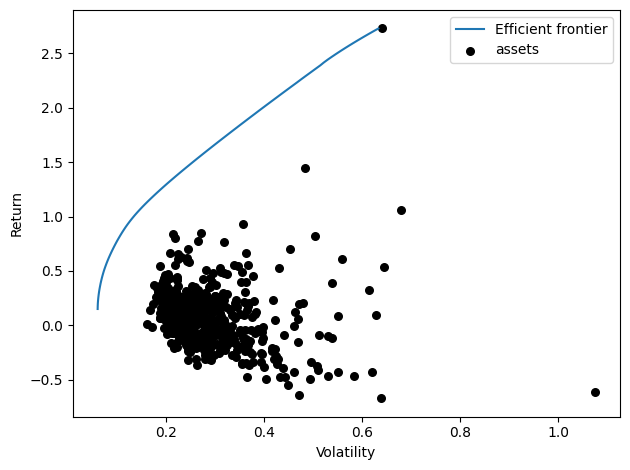

Expected annual return: 272.9%
Annual volatility: 63.3%
Sharpe Ratio: 4.31
(2.729194614952082, 0.6327123923352898, 4.313483737656611)


c:\Users\JW\Desktop\cryptoto\.venv\Lib\site-packages\cvxpy\problems\problem.py:1504: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

In [44]:
# Instantiate EF problem
ef = EfficientFrontier(mu, S)

# Generate plot
fig, ax = plt.subplots()
ef_max_sharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, show_assets=True, showfig=True)

# Find the tangency portfolio
ef_max_sharpe.max_sharpe()
ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Log performance
print(ef.portfolio_performance(verbose=True))

# Output
ax.set_title("Efficient Frontier")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()